- title: "Feature inversion"
- description: "Feature visualization with PyTorch"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [deep-learning, PyTorch, computer-vision, from scratch]
- image: images/Covers/2021_07_16.jpg
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Introduction

Feature visualization refers to an ensemle of techniques employed to extract, visualize or understand the information (weights, bias, feature maps) inside a neural network. [Olah et al. (2017)](https://distill.pub/2017/feature-visualization/) provide a good introduction to the subject, and the [openAI microscope](https://microscope.openai.com/models) allows one to explore pretrained convolutional networks through feature visualization.

Neural style transfer relies on the technique of **inversion** (see Mahendran and Vedaldi [2014](https://arxiv.org/pdf/1512.02017.pdf), [2016](https://arxiv.org/abs/1512.02017)). "*We do so by modelling a representation as a
function $\phi_0 = \phi(x_0)$ of the image $x_0$. Then, we attempt to recover the image from the information contained only in the code $\phi_0$*" (Mahendran and Vedaldi, 2016). Because some operation such as RELu or pooling operations (taking the max or mean of a subset of pixel) are destructive the image $x_0$ is not uniquely recoverable. For the same reason, it is easier to invert images from lower layers of the network than from higher ones. A couple of techniques such as total variation regularization or jittering the input image can help overcoming these theoretical limitations (see [Mordvintsev et al., 2016](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) and previous references).

## Algorithm outline

In this blogpost, I implement feature inversion as described in [Mahendran and Vedaldi (2016)](https://arxiv.org/abs/1512.02017). By doing so, I also lay the core foundation for the whole neural style transfer algorithm that I'll expand the next part of this series. The algorithm is implemented in PyTorch.

We have two images of interest: the *content image* (input) and the *generated image* (output). The algorithm and implementation goes as follows:
1. We import the necessary libraries
1. We create a `Image` class to store and transform images.
1. We download a pretrained netowrk and create a smaller neural network, `SmallNet` that implements only the lower layers that we need. That network takes an image as input and outputs the feature maps of requested layers.
1. We define a loss function between the *content* and *generated* feature maps, as well as a series of regularizers to limit inversion artefacts.
1. Finally, we instantiate all the classes and train the model.


# 1. Setup

We start by importing all the necessary libraries.

In [1]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from skimage import io
# from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

# 2. `Image` class

Next we define an `Image` class. This class stores the image. It also applies preprocessing when the class is instantiated. I also added a function to perform image jittering, either translating or rotating the image. This kind of transformation, when applied to the input (i.e. content) image has been shown to improve feature inversion, especially when attempting to recover higher layers in the network. In effect those transformations enforce correlation between neighbouring pixels and help recover the information that was lost during pooling operations ([Mahendran and Vedaldi, 2016](https://arxiv.org/abs/1512.02017)). However, making the image jump all over the place from one iteration of the solver to the other may render optimization difficult or unstable. Thus, I opted to implement jittering a a random walk of the translation distance and angle of rotation. During instanciation we will set the parameter `optimizable` to `False` for the *content image*, and `True` for the *generated image*. The image is cast into a `tensor` when `optimizable==False`, and into a `nn.Parameter` with `requires_grad==True` object when `optimizable==True`. Image values are clamped between 0 and 1 during the forward pass. 

In [45]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]) # Fixed values for PyTorch pretrained models
rgb_std = torch.tensor([0.229, 0.224, 0.225])

class Image(nn.Module):
    def __init__(self, img=None, optimizable=True, img_shape=[64,64], jit_max=2, angle_max=2.0):
        super(Image,self).__init__()
        
        self.img_shape = img_shape
        
        if type(img)==type(None):
            self.img = torch.randn([1, 3] + self.img_shape)
        else:
            self.img = img
            self.img = self.preprocess()

        if optimizable == True:
            self.img = nn.Parameter(self.img)
         
        self.jit_i = 0
        self.jit_j = 0
        self.jit_max = jit_max
        self.angle = 0.0
        self.angle_max = angle_max
    def preprocess(self):
        with torch.no_grad():
            transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToPILImage(),
                torchvision.transforms.Resize(self.img_shape),
                torchvision.transforms.ToTensor(),
            ])
            return transforms(self.img).unsqueeze(0)
            

    def postprocess(self):
        with torch.no_grad():
            img = self.img.data[0].to(rgb_std.device).clone()
            img.clamp_(0, 1)
            return torchvision.transforms.ToPILImage()(img.permute(1, 2, 0).permute(2, 0, 1))
          
    def jittered_image(self):
        with torch.no_grad():
            jit_max = 2
            temp = np.random.standard_normal(2)*2.0
            self.jit_i += temp[0]
            self.jit_j += temp[1]

            self.angle += np.random.standard_normal(1)[0]*1.0
            self.angle = np.clip(self.angle,-self.angle_max,self.angle_max)
            self.jit_i, self.jit_j = np.clip([self.jit_i, self.jit_j],-self.jit_max,self.jit_max)#.astype(int)
#             print(self.angle, self.jit_i, self.jit_j, temp)
            return torchvision.transforms.functional.affine(self.img.data, angle=self.angle, translate=(self.jit_i/self.img_shape[1], self.jit_j/self.img_shape[0]), scale=1., shear=[0.0,0.0])#,interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
            
        
    def forward(self, jitter=False):
        self.img.data.clamp_(0, 1)
        if jitter:
            return self.jittered_image()
        else:
            return self.img

# 3. `SmallNet` class

Next, we import a pretrained model from the PyTorch zoo. Here, I use VGG16 ([Simonyan and Zisserman, 2014](https://arxiv.org/abs/1409.1556)). The VGG architecture (printed below) is composed of a series of of blocks. The smallest block unit is composed of a convolutional layer + ReLU activation layer (**Conv2d+ReLU**). Larger blocks are composed of a series of **Conv2d+ReLU** followed by a maximum pooling (**MaxPool2d**) operation. The pooling operation divides the number of pixels by two. The complete VGG16 architecture also contains a final few fully connected layers to perform the classification, but we don't need those here. For testing I'll extract features from layer 7, and then again for layer 29 (last convolutional layer).

In [46]:
pretrained_net = torchvision.models.vgg16(pretrained=True)#.features.to(device).eval()
display(pretrained_net.features)
content_layer = [29]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

We are only interested in the features contains in the list of layers defined earlier in `content_layer`. Thus, we don't need to make a complete forward pass through the model. We need to feed our image to the VGG16 network up to the last layer of `content_layer` only. Thus, we create a small network class `SmallNet` that is a smaller version of the VGG16 network. We also add an initial normalization operation before the VGG16 network. 

A forward pass through `SmallNet` outputs a list of feature maps for specified layers (here we would specify the `content_layer` list). We will use `SmallNet` both on the *content* and *generated* image to obtain their respective feature maps. Here there is subtlety: the *content* image is not optimizable (i.e. `requires_grad==False`), but the *generated* image is optimizable (i.e. `requires_grad==False`). Thus, we need to *detach* the content image's feature map to avoid tracking their gradient during optimization. We also need to make copies of the feature maps to be used later during optimization. This part is essential but a bit tricky. When I implemented the algorithm, first, I didn't `clone()` the layers and backpropagation was crashing, but the error message is not very explicit. Then, I didn't detach the content feature maps. The backpropagation was not crashing and I was getting a reasonable output, but convergence was terrible and the results were quite underwhelming. It took me a while to figure out the problem.

In [47]:
class SmallNet(nn.Module):
    def __init__(self, pretrained_net, last_layer):
        super(SmallNet,self).__init__()
        self.net= nn.Sequential(*([torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)] + 
                     [pretrained_net.features[i]
                            for i in range(last_layer + 1)])).to(device).eval()

    def forward(self, X, extract_layers):
        # Passes the image X through the pretrained network and 
        # returns a list containing the feature maps of layers specified in the list extract_layers
        detach = not(X.requires_grad) # We don't want to keep track of the gradients on the content image
        feature_maps = []
        for il in range(len(self.net)):
            X = self.net[il](X)
            if (il-1 in extract_layers): # note: il-1 because I added a normalization layer before the pretrained net in self.net
                if detach:
                    feature_maps.append(X.clone().detach())    
                else:
                    feature_maps.append(X.clone())
                    
        return feature_maps

# 4. `Losses` class

The *content loss* is the mean squared error between the feature maps that correspond to the *content* and *generated* images. A number of artefacts commonly appear during image inversion. One of the main reason for these artefacts is that some of the information from the original image is destroyed by pooling operations, and to a lesser extent by convolution and ReLU operations. To decrease the effect of these artefacts, we add a number of regularizer to the loss function. The *intensity regularizer* discourages large color intensity. The *total variation regularizer* inhibits small wavelength variation (i.e. denoising). Each regularization term is associated with a weight. The losses and regularizers are described in detail in [Mahendran and Vedaldi (2016)](https://arxiv.org/abs/1512.02017).

In [48]:
class Losses(nn.Module):
    def __init__(self, img_ref, 
                 content_weight=1.0, tv_weight=0.0, int_weight=0.0, 
                 alpha=6, beta=1.5):
        super(Losses,self).__init__()
        # img_ref is used to compute a reference total variation and reference intensity
        # tv_weight: weight of the total variation regularizer
        # int_weight: weight of the intensity regularizer
        # alpha: exponent for the intensity regularizer
        # beta: exponent for the total variation regularizer
        self.content_weight = content_weight
        self.tv_weight = tv_weight
        self.int_weight = int_weight
        self.content_loss = 1e10
        self.tv_loss = 1e10
        self.int_loss = 1e10
        self.total_loss = 1e10
        
        self.alpha = alpha
        self.beta = beta
        
        self.B, self.V = self.get_regularizer_refs(img_ref)

    def get_content_loss(self, feature_map_gen, feature_map_content):
        # Mean squared error between generated and content image
        loss = 0
        for i in range(len(feature_map_content)):
            loss += F.mse_loss(feature_map_gen[i], 
                               feature_map_content[i].detach())
        return loss/(i+1)

    def get_regularizer_refs(self, img):
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        B = L2.mean()

        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
        V = L2.mean()
        return B, V

    def get_int_loss(self, img):
        # Intensity loss
        H = img.shape[2]
        W = img.shape[3]
        C = img.shape[1]
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        
        loss = 1./H/W/C/(self.B**self.alpha) * torch.sum(L2**self.alpha)
        
        return loss
    
    def get_TV_loss(self, img):
        # Total variation loss
        
        H = img.shape[2]
        W = img.shape[3]
        C = img.shape[1]
        eps = 1e-10 # avoids accidentally taking the sqrt of a negative number because of rounding errors

        # total variation
        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        # I ignore the first row or column of the image when computing the norm, in order to have vectors with matching sizes
        # Thus, d_dx and d_dy are not strictly colocated, but that should be a good enough approximation because neighbouring pixels are correlated
        L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
        TV = torch.sum(L2**self.beta) # intensity regularizer
        loss = 1./H/W/C/(self.V**self.beta) * TV
                
        return loss
    
    def forward(self,img,feature_map, feature_map_target):
        self.content_loss = self.get_content_loss(feature_map, feature_map_target)
        self.int_loss = self.get_int_loss(img)
        self.tv_loss = self.get_TV_loss(img)
        
        self.total_loss = ( self.content_weight*self.content_loss 
                    + self.int_weight*self.int_loss 
                    + self.tv_weight*self.tv_loss )
        
        return self.total_loss

# 5. Training
## 5.1. Setup training

We create two instances of the `Image` class, for the *content* and *generated* images, respectively. We instantiate `SmallNet` and pass it the `content_layer`. We instantiate `Losses` and we chose weights for the regularizers. We create an optimizer and pass it the optimizable *generated* image. Here, we use L-BFGS as recommended by [Gatys et al. (2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). We also define conditions of absolute and relative loss limits to stop training, and an option to jitter or not the input image during training.  Jittering is useful to better inverse features but can cause training to not converge, therefore it is recommended to stop jittering once a reasonnable result is reached, and then optimize a bit more without jittering. We implement this option by specifying maximum number of steps for which jittering is active (`jitter_nsteps==0` deactivates jittering altogether).

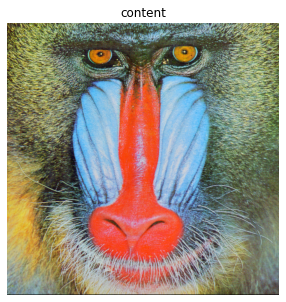

In [50]:
device = 'cpu'

# Images
content_im = skimage.io.imread("https://github.com/scijs/baboon-image/blob/master/baboon.png?raw=true")
fig, ax = plt.subplots(1,1,figsize=[5,5])
_ = plt.imshow(content_im); plt.title("content"); _ = plt.axis("off")


img_shape = [256, int(256*content_im.shape[1]/content_im.shape[0])]
img_content = Image(img=content_im, optimizable=False, img_shape=img_shape).to(device)
img_gen = Image(None, optimizable=True, img_shape=img_shape).to(device)

# SmallNet
net = SmallNet(pretrained_net, content_layer[-1])

# Losses
loss_fn = Losses(img_content(), 
                 tv_weight=0.2, 
                 int_weight=0.0)

# Optimizer
optimizer = torch.optim.LBFGS(img_gen.parameters(),lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
abs_loss_limit = 1e-3
rel_loss_limit = 1e-7

# Other options
n_steps = 100
n_out = 1 # how often (in number of time steps) to plot the the updated image during inversion
jitter_nsteps = 50 # Jitter the input image for the first that many steps

# 5.2. Train

Here, we train the model. At each iteration we compute the feature maps of the *generated* image and compare it to the feature maps of the *content image* to compute the loss. The feature maps of the *content image* are computed only once if `jitter==False` or at each epoch otherwise. We visualize the updated *generated* image every few epochs along the current values of loss and regularizers.

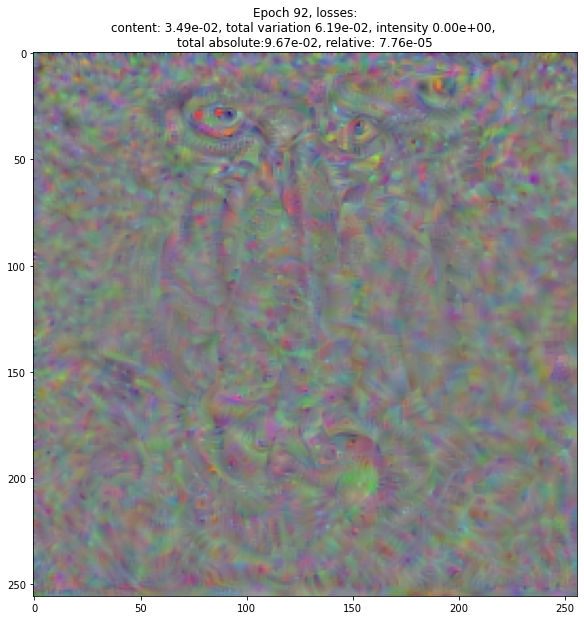

KeyboardInterrupt: 

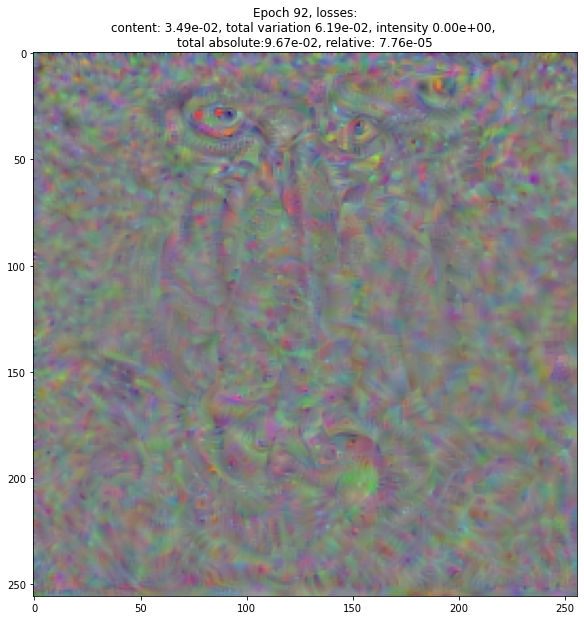

In [51]:
fig, ax = plt.subplots(1,1,figsize=[10,10])

# for sanity
if jitter_nsteps<0:
    jitter_nsteps = 0

def closure():
    optimizer.zero_grad()
    fm_gen = net(img_gen(), content_layer)
    loss = loss_fn(img_gen(), fm_gen, fm_content)
    loss.backward()
    return loss

last_loss = 1e10
frame = 0

for i in range(n_steps):  
    if i%n_out==0:
        with torch.no_grad():
            plt.clf()
            plt.imshow(img_gen.postprocess())
            
            if i>0:
                rel_loss = torch.abs(last_loss-loss_fn.total_loss)
            else:
                rel_loss = 1e10
            plt.title(f"Epoch {i:02}, losses:\n" + 
                      f"content: {loss_fn.content_weight*loss_fn.content_loss:.2e}, " + 
                      f"total variation {loss_fn.tv_weight*loss_fn.tv_loss:.2e}, " +
                      f"intensity {loss_fn.int_weight*loss_fn.int_loss:.2e}, \n" + 
                      f"total absolute:{loss_fn.total_loss:.2e}, relative: {rel_loss:.2e}")
            
            clear_output(wait = True)
            display(fig)
        
            plt.savefig(f"./Output/Frame_{i:05d}.jpg")
            if i>0:
                if loss_fn.total_loss<abs_loss_limit:
                    clear_output(wait = True)
                    print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
                    break
                if torch.abs(last_loss-loss_fn.total_loss)<rel_loss_limit:
                    clear_output(wait = True)
                    print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
                    break

                if loss_fn.total_loss.isnan():
                    print(f'stopped because loss is NaN')
                    break
                    
    last_loss = loss_fn.total_loss            
    if i<jitter_nsteps:
        fm_content = net(img_content(jitter=True), content_layer)
    elif i==jitter_nsteps:
        fm_content = net(img_content(jitter=False), content_layer)
    optimizer.step(closure)
    scheduler.step()

# Results

The algorithm can reconstruct an image pretty close to the original from shallow layers, but the inversion becomes more abstract with deeper layers. The color reconstruction also becomes increasingly unfaithful the deeper we go. For example, here are illustrations of the optimization process on layer 7 (left), and 29, i.e. last layer (right). Also, you can both output images are jittered, the jittering is only clearly visible for layer 7. 

<img src="https://github.com/abauville/blog/raw/master/images/2021_07_16_feature_inversion/layer_7.gif" alt="Optimization layer 7" width="360"/> <img src="https://github.com/abauville/blog/raw/master/images/2021_07_16_feature_inversion/layer_29.gif" alt="Optimization layer 29" width="360"/>

# Conclusion

In this blogpost I implemented feature visualization and layed the foundation for my implementation of neural style transfer. My implementation of feature visualization follows the recommandation of [Mahendran and Vedaldi (2016)](https://arxiv.org/abs/1512.02017). I implemented some of the techniques described by [Olah et al. (2017)](https://distill.pub/2017/feature-visualization/) to improve the inversion of deep layers, such as total variation and intensity regularization or jittering the output image. I obtain a clear output for relatively shallow layers, but there is room to improvement regarding deeper layers. I found that the trickiest part of the implementation, and where I spent the most time debugging was in the feature map extraction. At this point it is important to clone and detach feature maps appropriately. Failing to do so may break backpropagation, or worse, backpropagation can go on but with the wrong feature maps which result underwhelming yet reasonnable output. In that case you might make the mistake of trying to tune the parameters rather than looking for a bug.